In [1]:
import os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torchvision
import tifffile as tiff
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from copy import deepcopy
import random
from sklearn.preprocessing import normalize

from collections import Counter
from scipy.stats import mode

In [26]:
ex =  torch.load('ex.pt')
control =  torch.load('cond7.pt')
sd =  torch.load('sd.pt')
#cosine_centroid = torch.load('ex_cosin_centroid.pt')
#cosine_centroid = torch.load('cond7_cosin_centroid.pt')
cosine_centroid = torch.load('sd_cosin_centroid.pt')


C:\Users\k54739\AppData\Local\Temp\ipykernel_93588\1973155892.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ex =  torch.load('ex.pt')
C:\Users\k54739\AppData\Local\Tem

In [27]:
print(ex.shape)
print(control.shape)
print(sd.shape)
print(cosine_centroid.shape)


torch.Size([40, 27648])
torch.Size([280, 27648])
torch.Size([103, 27648])
torch.Size([1, 27648])


In [28]:
import torch

def normalize_tensor(tensor, dim=1):
    """
    Normalize a PyTorch tensor along the specified dimension.
    
    Args:
        tensor (torch.Tensor): Input tensor to normalize (e.g., shape [N, D]).
        dim (int): Dimension along which to normalize. Default is 1 (rows).
    
    Returns:
        torch.Tensor: Normalized tensor with the same shape as input.
    """
    # Compute the L2 norm along the specified dimension
    norm = torch.norm(tensor, p=2, dim=dim, keepdim=True)
    
    # Avoid division by zero
    norm = torch.clamp(norm, min=1e-8)
    
    # Normalize the tensor
    normalized_tensor = tensor / norm
    return normalized_tensor


In [29]:
ex[0].shape

torch.Size([27648])

In [30]:
# Normalize each group
normalized_ex = normalize_tensor(ex, dim=1)  # Normalize each row
normalized_control = normalize_tensor(control, dim=1)
normalized_sd = normalize_tensor(sd, dim=1)
normalised_cosine_centroid = cosine_centroid

# Print shapes to verify
print("Normalized shapes:")
print(normalized_ex.shape)  # Should match ex.shape
print(normalized_control.shape)  # Should match control.shape
print(normalized_sd.shape) 
print(normalised_cosine_centroid.shape) 


Normalized shapes:
torch.Size([40, 27648])
torch.Size([280, 27648])
torch.Size([103, 27648])
torch.Size([1, 27648])


In [31]:
#check for nomralisation

import numpy as np

# Calculate the L2 norm of each row in exp_np_norm
norms = np.linalg.norm(cosine_centroid, axis=1)

# Check if all norms are close to 1
if np.allclose(norms, 1.0, atol=1e-6):
    print("All feature vectors are normalized.")
else:
    print("Some feature vectors are not normalized.")
    print("Norms:", norms)


All feature vectors are normalized.


In [32]:
import torch
import matplotlib.pyplot as plt

def calculate_and_plot_cosine_distances(centroid, groups, group_names, bins=20):
    """
    Calculate cosine distances from a centroid to each vector in multiple groups and plot distributions.
    
    Args:
        centroid (torch.Tensor): Normalized centroid tensor of shape [1, D].
        groups (list of torch.Tensor): List of normalized tensors, each group of shape [N, D].
        group_names (list of str): Names of the groups (e.g., ["Control", "Exploded", "Single Dose"]).
        bins (int): Number of bins for the histogram.
        
    Returns:
        dict: Dictionary containing cosine distances for each group.
    """
    assert len(groups) == len(group_names), "Each group must have a corresponding name"
    
    cosine_distances = {}
    
    # Calculate cosine distances for each group
    for group, name in zip(groups, group_names):
        # Ensure the centroid and group are on the same device
        centroid = centroid.to(group.device)
        
        # Calculate cosine similarity
        cosine_similarity = torch.nn.functional.cosine_similarity(group, centroid.expand_as(group), dim=1)
        
        # Convert to cosine distances
        distances = 1 - cosine_similarity
        
        # Store distances
        cosine_distances[name] = distances.cpu().numpy()
    
    # Plot distributions
    plt.figure(figsize=(12, 6))
    for name, distances in cosine_distances.items():
        plt.hist(distances, bins=bins, alpha=0.6, label=name, edgecolor="black")
    
    plt.title("Cosine Distance Distribution Across Groups", fontsize=14)
    plt.xlabel("Cosine Distance", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.3)
    plt.show()
    
    return cosine_distances


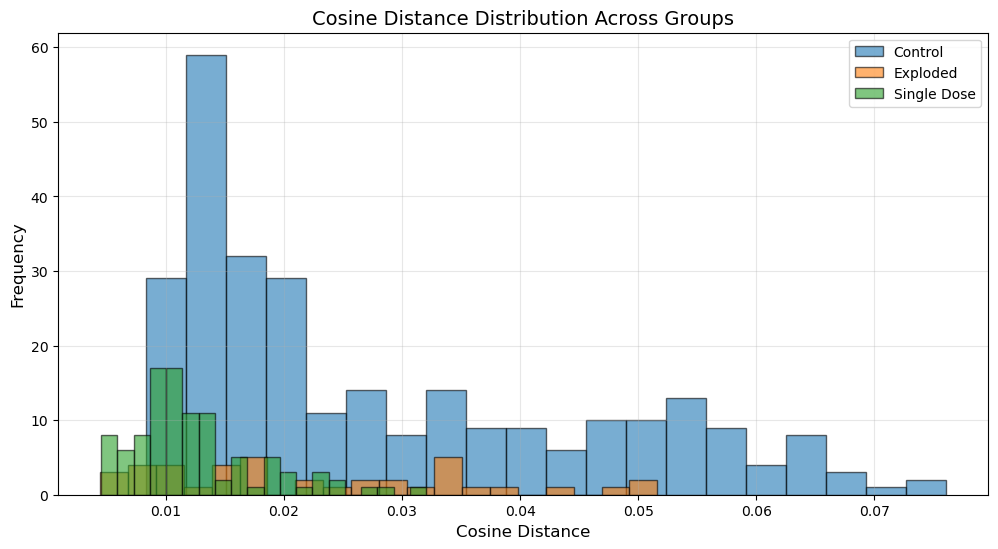

In [33]:
# Groups and names
groups = [normalized_control, normalized_ex, normalized_sd]
group_names = ["Control", "Exploded", "Single Dose"]

# Calculate distances and plot
cosine_distances = calculate_and_plot_cosine_distances(
    centroid=normalised_cosine_centroid,
    groups=groups,
    group_names=group_names,
    bins=20
)

# Access calculated distances
control_distances = cosine_distances["Control"]
exploded_distances = cosine_distances["Exploded"]
single_dose_distances = cosine_distances["Single Dose"]

In [38]:
import torch
import numpy as np

def calculate_outer_cluster_errors(cosine_distances):
    """
    Calculate errors and accuracy based on the distribution of cosine distances.
    
    Args:
        cosine_distances (dict): Dictionary containing cosine distances for each group.
        
    Returns:
        dict: Dictionary containing errors and accuracy.
    """
    # Step 1: Calculate the mean of each group
    group_means = {name: np.mean(distances) for name, distances in cosine_distances.items()}
    print("Group Means:", group_means)
    
    # Step 2: Find the group with the middle mean
    sorted_means = sorted(group_means.items(), key=lambda x: x[1])  # Sort by mean value
    middle_cluster_name, middle_mean = sorted_means[1]  # Middle cluster
    print(f"Middle Cluster: {middle_cluster_name} with mean = {middle_mean}")
    
    # Step 3: Calculate min and max of the middle cluster
    middle_distances = cosine_distances[middle_cluster_name]
    middle_cluster_min = np.min(middle_distances)
    middle_cluster_max = np.max(middle_distances)
    print(f"Middle Cluster Range: Min = {middle_cluster_min}, Max = {middle_cluster_max}")
    
    # Step 4: Error Calculation
    # First cluster (smallest mean)
    first_cluster_name, _ = sorted_means[0]
    first_cluster_distances = cosine_distances[first_cluster_name]
    first_cluster_errors = np.sum(first_cluster_distances > middle_cluster_min)
    
    # Third cluster (largest mean)
    third_cluster_name, _ = sorted_means[2]
    third_cluster_distances = cosine_distances[third_cluster_name]
    third_cluster_errors = np.sum(third_cluster_distances < middle_cluster_max)
    
    # Total errors
    total_errors = first_cluster_errors + third_cluster_errors
    print(f"First Cluster Errors: {first_cluster_errors}")
    print(f"Third Cluster Errors: {third_cluster_errors}")
    print(f"Total Errors: {total_errors}")
    
    # Step 5: Accuracy Calculation
    total_points = sum(len(distances) for distances in cosine_distances.values())
    non_errors = total_points - total_errors
    accuracy = non_errors / total_points
    print(f"Total Points: {total_points}, Non-Errors: {non_errors}, Accuracy: {accuracy:.2%}")
    
    # Return results
    return {
        "group_means": group_means,
        "middle_cluster": middle_cluster_name,
        "middle_cluster_range": (middle_cluster_min, middle_cluster_max),
        "first_cluster_errors": first_cluster_errors,
        "third_cluster_errors": third_cluster_errors,
        "total_errors": total_errors,
        "accuracy": accuracy,
    }

# Example Usage with Previous Results
results = calculate_outer_cluster_errors(cosine_distances)


Group Means: {'Control': 0.028050900553929906, 'Exploded': 0.022564906818240305, 'Single Dose': 0.012432179882721618}
Middle Cluster: Exploded with mean = 0.022564906818240305
Middle Cluster Range: Min = 0.004436324250240653, Max = 0.051616672931008134
First Cluster Errors: 103
Third Cluster Errors: 236
Total Errors: 339
Total Points: 423, Non-Errors: 84, Accuracy: 19.86%


In [34]:
control_distances.shape

(280,)

In [35]:
exploded_distances.shape

(40,)

In [36]:
single_dose_distances.shape

(103,)

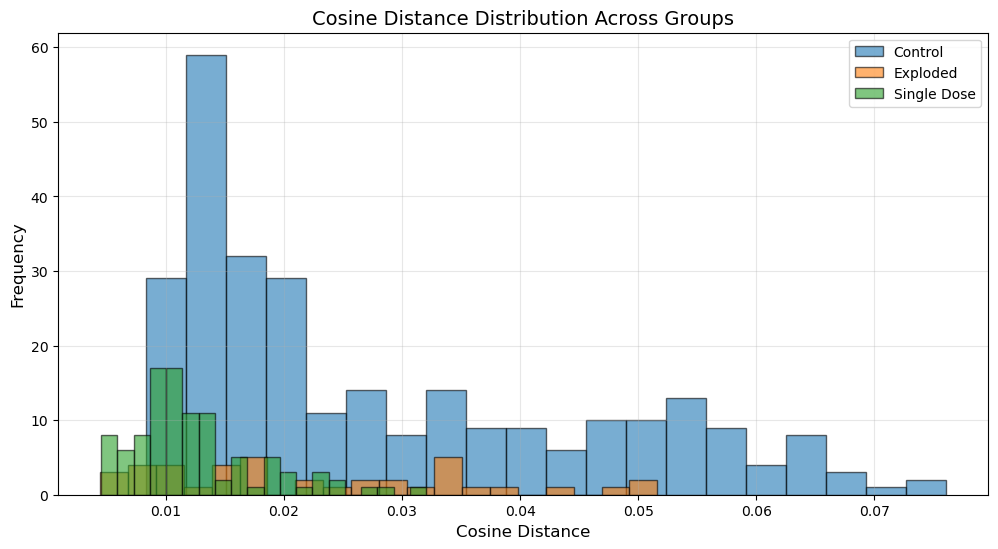


Metrics:
Group-Wise Ranking Accuracy: 0.8128

Cosine Distances:
Control: [0.01862535 0.01878941 0.0146459  0.01852358 0.00828509] ...
Exploded: [0.04907284 0.03549081 0.01779407 0.01417649 0.03869662] ...
Single Dose: [0.01160673 0.01566016 0.01108466 0.02055134 0.02443956] ...

Group-Wise Ranking Accuracy: 0.8128


In [39]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def calculate_and_plot_cosine_distances(centroid, groups, group_names, bins=20):
    """
    Calculate cosine distances from a centroid to each vector in multiple groups,
    plot distributions, and compute Group-Wise Ranking Accuracy.
    
    Args:
        centroid (torch.Tensor): Normalized centroid tensor of shape [1, D].
        groups (list of torch.Tensor): List of normalized tensors, each group of shape [N, D].
        group_names (list of str): Names of the groups (e.g., ["Control", "Exploded", "Single Dose"]).
        bins (int): Number of bins for the histogram.
        
    Returns:
        dict: Dictionary containing cosine distances for each group and metrics.
    """
    assert len(groups) == len(group_names), "Each group must have a corresponding name"
    
    cosine_distances = {}
    
    # Calculate cosine distances for each group
    for group, name in zip(groups, group_names):
        # Ensure the centroid and group are on the same device
        centroid = centroid.to(group.device)
        
        # Calculate cosine similarity
        cosine_similarity = torch.nn.functional.cosine_similarity(group, centroid.expand_as(group), dim=1)
        
        # Convert to cosine distances
        distances = 1 - cosine_similarity
        
        # Store distances
        cosine_distances[name] = distances.cpu().numpy()
    
    # Plot distributions
    plt.figure(figsize=(12, 6))
    for name, distances in cosine_distances.items():
        plt.hist(distances, bins=bins, alpha=0.6, label=name, edgecolor="black")
    
    plt.title("Cosine Distance Distribution Across Groups", fontsize=14)
    plt.xlabel("Cosine Distance", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.3)
    plt.show()
    
    # Compute Group-Wise Ranking Accuracy
    group_wise_accuracy = compute_group_wise_ranking_accuracy(cosine_distances, group_names)
    
    print("\nMetrics:")
    print(f"Group-Wise Ranking Accuracy: {group_wise_accuracy:.4f}")
    
    return {
        "cosine_distances": cosine_distances,
        "group_wise_accuracy": group_wise_accuracy
    }

def compute_group_wise_ranking_accuracy(cosine_distances, group_names):
    """
    Compute the Group-Wise Ranking Accuracy metric.
    
    Args:
        cosine_distances (dict): Dictionary of cosine distances for each group.
        group_names (list of str): Names of the groups in ranking order.
        
    Returns:
        float: Group-wise ranking accuracy.
    """
    # Assign numerical labels to each group based on the order of group_names
    all_distances = []
    all_labels = []
    
    for i, name in enumerate(group_names):
        distances = cosine_distances[name]
        all_distances.append(distances)
        all_labels.append(np.full_like(distances, i))  # Assign label i to this group
    
    # Combine all distances and labels
    all_distances = np.concatenate(all_distances)
    all_labels = np.concatenate(all_labels)
    
    # Sort all distances along with their labels
    sorted_indices = np.argsort(all_distances)
    sorted_labels = all_labels[sorted_indices]
    
    # Check if group order is preserved
    correct_transitions = 0
    total_transitions = 0
    for i in range(1, len(sorted_labels)):
        if sorted_labels[i - 1] <= sorted_labels[i]:
            correct_transitions += 1
        total_transitions += 1
    
    accuracy = correct_transitions / total_transitions if total_transitions > 0 else 0
    return accuracy


# Groups and names
groups = [normalized_control, normalized_ex, normalized_sd]
group_names = ["Control", "Exploded", "Single Dose"]

# Calculate distances, plot, and get metrics
results = calculate_and_plot_cosine_distances(
    centroid=normalised_cosine_centroid,
    groups=groups,
    group_names=group_names,
    bins=20
)

# Access results
cosine_distances = results["cosine_distances"]
group_wise_accuracy = results["group_wise_accuracy"]

# Print results
print("\nCosine Distances:")
for group, distances in cosine_distances.items():
    print(f"{group}: {distances[:5]} ...")  # Print first 5 distances for brevity
print(f"\nGroup-Wise Ranking Accuracy: {group_wise_accuracy:.4f}")
